In [1]:
# utils
import pandas as pd
import numpy as np

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# learning
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
# keras

from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Recall
import keras.backend as K


In [2]:
# IMPORT DATA

#import shower summary tables
fn_ph = pd.read_csv("../shower_data/350shower/final_ph.csv",index_col=0)
fn_pr = pd.read_csv("../shower_data/350shower/final_pr.csv",index_col=0)

In [3]:
# DATA TABLE CREATION

#join them
all_ph = fn_ph.append(fn_pr)
all_ph.reset_index(drop=True, inplace=True)

# log10 to dt, E, and counts
all_ph[["dt"]]=all_ph["dt"].apply(np.log10)
all_ph[["E"]]=all_ph["E"].apply(np.log10)
all_ph[["dxy"]]=all_ph["dxy"].apply(np.log10)
all_ph[["muon_detector_array"]]=all_ph["muon_detector_array"].apply(lambda x : np.log10(x+1))
all_ph[["em_scintillator_array"]]=all_ph["em_scintillator_array"].apply(lambda x : np.log10(x+1))

### Features and Target definition 
The machine Learning model will take the features and train to predict the correct target. In the future, the model will receive a set of features and predict a probability of belonging to the "1" target (probability of being a proton-induced shower). then, we can play with a threshold over the probabilitiy to determine the desired specificity and recall.

In [4]:
#all feautres
X =  all_ph[["muon_detector_array","em_scintillator_array","dt","dxy"]].values
#target
y = np.array([0 if d ==1 else 1 for d in all_ph["origin"].values])#.reshape(-1,1)


In [5]:
#splitting in train and test sample. the proportion of the test sample is set on "test_size"
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)


## Model probability prediction

Some models allow to show the probability computed for each set of features to belong in each class. Since we have 2 classes, we compute 2 probabilities (Probability of being a GS (0) and probability of being a PS(1))  or a probability a being positive (a PS). A Classifer uses this probability to decide on which class should the new set of features be classified, but the probability threshold of this decision depends on each model, that's why using the probability instead of the direct prediction is better for setting an unbalanced classification.


### Error assessment function

Given the expected (correct) categories (y-values) for the features and the probabilities predicted with the model, we want to set the probability threshold so that when applying the threshold to the pobabilities the recall is maximized and the specificity is mantained over certain threshold. 

In order to find this threshold the Error Assessment function is defined. The function does a sweep of the threshold from 0 to 1, for each step it saves the proportion of PS misclassificated (1-recall) and the proportion of GS misclassificated (1-specificity) searching for the best threshold value. 

In [6]:
# y_test   real classes
# y_pred  predicted classes
# proton_tol  tolerance of miclassificated PS
# photon_loss_tol  tolerance for misclassifed photons
# resol resolution in the probability space, number of steps steps is defined as 1/resol

def error_assessment(y_test,y_pred,proton_tol=1E-4,photon_loss_tol=0.5,resol = 1E-4):
    # number of steps
    steps = int(1/resol)+1
    thresholds = np.linspace(0,1,steps)
    
    
    protons_passed = [] # values of (1-recall) . proportion of protons misclassificated
    photons_npassed = [] # values of (1-specificity). proportion of photons misclassificated

    # better threshold : [threshold value, 1-recall , 1 - spec.]
    ideal_th = [0,1,1] 
    
    # is ther at least one candidate for threshold?
    found  = False
    
    
    for th in thresholds:
        # create an array with the classes decided with thresshold = th
        # if probability above th, then the class is 1. if else , 0.
        y_c = [1  if  v > th else 0 for v in y_pred.reshape(-1)]
        
        #true negatives, false positives, false negatives, true positives
        tn, fp, fn, tp = confusion_matrix(y_test.reshape(-1),y_c).ravel()


        pr_pass = fn/(fn+tp) # 1 -recall
        ph_pass = fp/(tn+fp) # 1 - specificity

        # the better threshold is only updated if tolerance values are respected and the candidate minimizes
        # at least one value (1-recall) or (1-specificity)
        if( ph_pass<photon_loss_tol and pr_pass < proton_tol and (ph_pass<ideal_th[2] or pr_pass < ideal_th[1])):
            ideal_th = [th,pr_pass,ph_pass]
            found = True

        protons_passed.append(pr_pass) 
        photons_npassed.append(ph_pass) 

    # if there is not at least one candidate
    if(not found):
        print("Warning! No minimal threshold conditions found in all the threshold sweep")
    else:
        print("The best threshold is in {} where {}% of protons are misclassified and {}% of photons are miscalssified".format(ideal_th[0],round(ideal_th[1]*100,2),round(ideal_th[2]*100,2)))
    return {
        "thresholds":thresholds,
        "protons_accepted":protons_passed,
        "photons_rejected":photons_npassed,
        "best_threshold":ideal_th
    }

## Model trainning

Now some models are evaluated using the Error assessment function

### Logistic Regression

for simplicity let's start by using a Logistic Regression model to predict the classes. 

In [7]:
model = LogisticRegression(solver="liblinear")
model.fit(x_train,y_train)

LogisticRegression(solver='liblinear')

In [8]:
# we need the probability of being positive (1) [PS]
# selct the second column of data since the first is the probability of being negative (0)
y_pred = model.predict_proba(x_test)[:,1]

In [9]:
y_pred[:10] # a look into the probability set

array([0.97179582, 0.99882308, 0.99920109, 0.00240402, 0.01105849,
       0.03254534, 0.01104918, 0.00218366, 0.02108461, 0.96363689])

The best threshold is in 0.3337 where 0.0% of protons are misclassified and 0.0% of photons are miscalssified


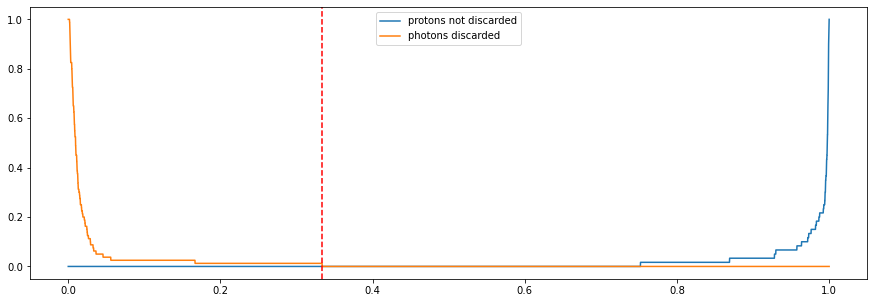

In [10]:
# use the error assessment function to find an optimal threshold value
err_ass =  error_assessment(y_test,y_pred,resol=1E-4)

# for plotting
thresholds = err_ass["thresholds"]
protons_passed = err_ass["protons_accepted"]
photons_npassed = err_ass["photons_rejected"]

# threshold
ideal_th = err_ass["best_threshold"]


# plot
plt.figure(figsize=(15,5))
plt.plot(thresholds,protons_passed,label="protons not discarded")
plt.plot(thresholds,photons_npassed,label="photons discarded")
plt.axvline(ideal_th[0],c="r",linestyle="--")
plt.legend()


### Gaussian model Classificator

In [11]:
# RBF kernel 
kernel = 5.0 * RBF(5.0)
model = GaussianProcessClassifier(kernel=kernel,random_state=0)
model.fit(x_train, y_train)


GaussianProcessClassifier(kernel=2.24**2 * RBF(length_scale=5), random_state=0)

The best threshold is in 0.3713 where 0.0% of protons are misclassified and 0.0% of photons are miscalssified


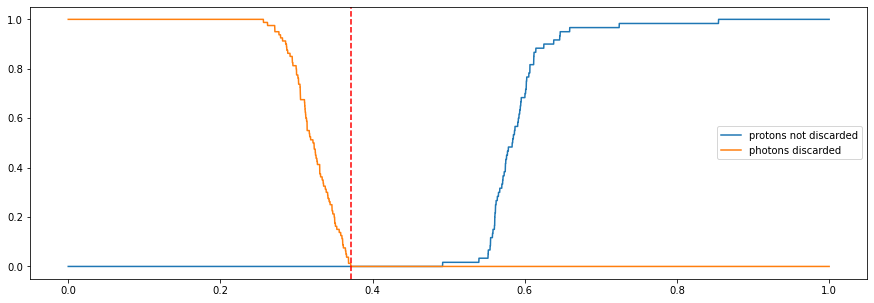

In [12]:
# we need the probability of being positive (1) [PS]
# selct the second column of data since the first is the probability of being negative (0)
y_pred = model.predict_proba(x_test)[:,1]

# use the error assessment function to find an optimal threshold value
err_ass =  error_assessment(y_test,y_pred,resol=1E-4)

thresholds = err_ass["thresholds"]
protons_passed = err_ass["protons_accepted"]
photons_npassed = err_ass["photons_rejected"]
ideal_th = err_ass["best_threshold"]

# plot
plt.figure(figsize=(15,5))
plt.plot(thresholds,protons_passed,label="protons not discarded")
plt.plot(thresholds,photons_npassed,label="photons discarded")
plt.axvline(ideal_th[0],c="r",linestyle="--")
plt.legend()

### Neural Network

Just to check an example of complex models lets use a shallow Neural Network to classify.

In [13]:
# NN architecture 
model = Sequential()
# 4 neuron input layer
model.add(Dense(4, activation='relu'))

# 20 neuron hidden layer
model.add(Dense(20, activation='relu'))

# output neuron
model.add(Dense(1, activation='sigmoid'))

#compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Recall()])

In [14]:
model.fit(x_train,y_train,epochs=200,batch_size=128,verbose=0,class_weight={0:0.2,1:0.8})
# class_weight determines the relevance of identifying positive cases (PS) over negative cases (GS) 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [15]:
# in this case the prediction is already a value between 0 and 1
y_pred = model.predict(x_test)

The best threshold is in 0.7028 where 0.0% of protons are misclassified and 0.0% of photons are miscalssified


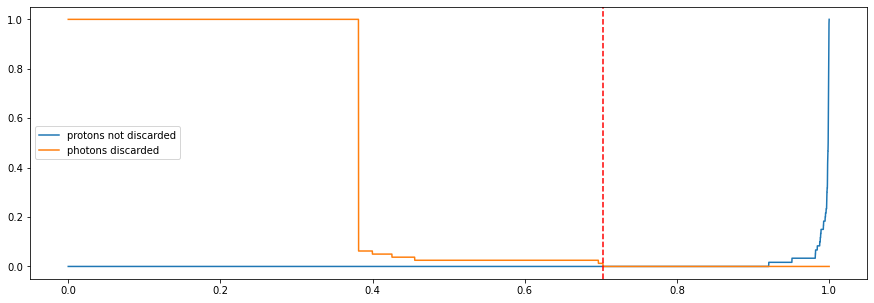

In [16]:
err_ass =  error_assessment(y_test,y_pred,resol=1E-4)
thresholds = err_ass["thresholds"]
protons_passed = err_ass["protons_accepted"]
photons_npassed = err_ass["photons_rejected"]
ideal_th = err_ass["best_threshold"]

plt.figure(figsize=(15,5))

plt.plot(thresholds,protons_passed,label="protons not discarded")
plt.plot(thresholds,photons_npassed,label="photons discarded")
plt.axvline(ideal_th[0],c="r",linestyle="--")
plt.legend()
